In [1]:
import pandas as pd
import numpy as np
import os
import glob
import ast
# !pip install ppscore
import ppscore as pps

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

In [3]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tslearn.clustering import TimeSeriesKMeans

In [5]:
import re 
import urllib.request 
from bs4 import BeautifulSoup 

In [6]:
data = pd.read_csv('data.csv')
genres = pd.read_csv('data_by_genres.csv')
year = pd.read_csv('data_by_year.csv')
artist = pd.read_csv('data_by_artist.csv')
wgenres = pd.read_csv('data_w_genres.csv')

# Data overview

In [7]:
data.head(3)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.634,1920
1,0.643,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.950,1920
2,0.993,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.689,1920


In [11]:
artist.sample(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
6217,DJ Gregory,0.000302,0.799000,436787.000000,0.72200,8.300000e-01,0.054700,-9.3090,0.06680,123.996000,0.929000,5.000000,8,1,1
18456,Mario del Monaco,0.967733,0.363967,213864.033333,0.23711,8.250267e-02,0.299577,-16.7482,0.06463,91.731533,0.248743,0.566667,1,1,30
31160,Wilhelm Felden,0.932250,0.331500,243423.250000,0.19675,7.325000e-07,0.211250,-18.5895,0.05335,102.001250,0.384250,0.000000,5,1,4


In [9]:
genres.head(3)

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.2841,352593.2,0.159580,0.484374,0.16858,-22.153400,0.062060,91.351000,0.143380,6.6,4,1
1,432hz,0.485515,0.3120,1047430.4,0.391678,0.477250,0.26594,-18.131267,0.071717,118.900933,0.236483,41.2,11,1
2,8-bit,0.028900,0.6730,133454.0,0.950000,0.630000,0.06900,-7.899000,0.292000,192.816000,0.997000,0.0,5,1


In [14]:
genres.shape

(3232, 14)

In [15]:
data.shape

(174389, 19)

In [16]:
artist.shape

(32539, 15)

In [17]:
wgenres.shape

(32539, 16)

In [18]:
year.shape

(102, 14)

In [19]:
# моя любимая группа
artist[artist.artists.str.contains('Breaking')].head(3)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
3827,Breaking Benjamin,0.014119,0.430102,224341.816327,0.851163,0.08578,0.137522,-4.852939,0.05892,134.312714,0.382837,51.408163,8,1,98


Агрегация нам нежелательна, так как теряются данные. Табличка с артистами получена при помощи агрегации. Табличка с жанрами 'wgenres' добавляет один столбец. Нам могут понадобиться жанры, но их надо аккуратно объединить с основной таблицей. Поэтому буду преимущественно работать с табличкой без агрегации (data).

In [12]:
data['duration_s'] = data['duration_ms'] / 60
data.drop('duration_ms', axis=1, inplace=True)

In [13]:
# все числовые столбцы, которые будут полезны
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.to_list()

In [15]:
# удаляю из них признаки, которые не понадобятся
drop_useless_cols = ['key']
[num_cols.remove(i) for i in drop_useless_cols]
None

ValueError: list.remove(x): x not in list

In [16]:
len(num_cols)

14

In [17]:
round(data[num_cols].describe(), 2)

,acousticness,danceability,energy,explicit,instrumentalness,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,duration_s
count,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00,174389.00
mean,0.50,0.54,0.48,0.07,0.20,0.21,-11.75,0.70,25.69,0.11,117.01,0.52,1977.06,3880.17
std,0.38,0.18,0.27,0.25,0.33,0.18,5.69,0.46,21.87,0.18,30.25,0.26,26.91,2473.26
min,0.00,0.00,0.00,0.00,0.00,0.00,-60.00,0.00,0.00,0.00,0.00,0.00,1920.00,82.28
25%,0.09,0.41,0.25,0.00,0.00,0.10,-14.91,0.00,1.00,0.04,93.93,0.31,1955.00,2768.88
50%,0.52,0.55,0.46,0.00,0.00,0.14,-10.84,1.00,25.00,0.05,115.82,0.54,1977.00,3429.78
75%,0.90,0.67,0.71,0.00,0.25,0.27,-7.50,1.00,42.00,0.08,135.01,0.74,1999.00,4428.67
max,1.00,0.99,1.00,1.00,1.00,1.00,3.86,1.00,100.00,0.97,243.51,1.00,2021.00,88971.70


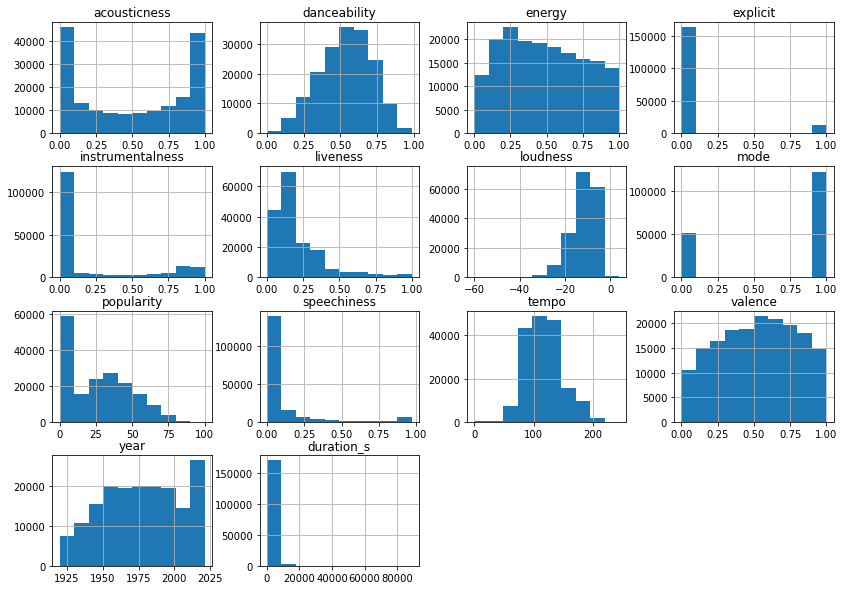

In [18]:
data[num_cols].hist(figsize=(14, 10))
plt.show()

In [19]:
all_num_cols = data.select_dtypes(include=['int64', 'float64']).columns.to_list()
matrix_df = pps.matrix(data[all_num_cols])[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore').round(2)

Или заменить на обычную корреляцию?

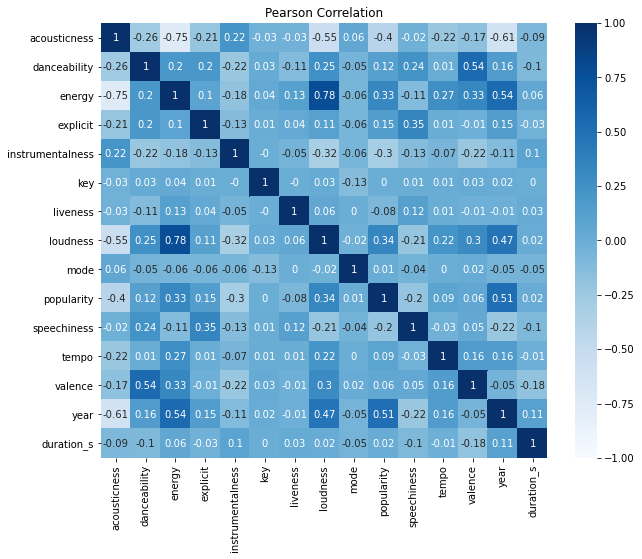

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[all_num_cols].corr().round(2), vmin=-1, vmax=1, cmap="Blues", linewidths=0, annot=True)
plt.title('Pearson Correlation')
plt.show()

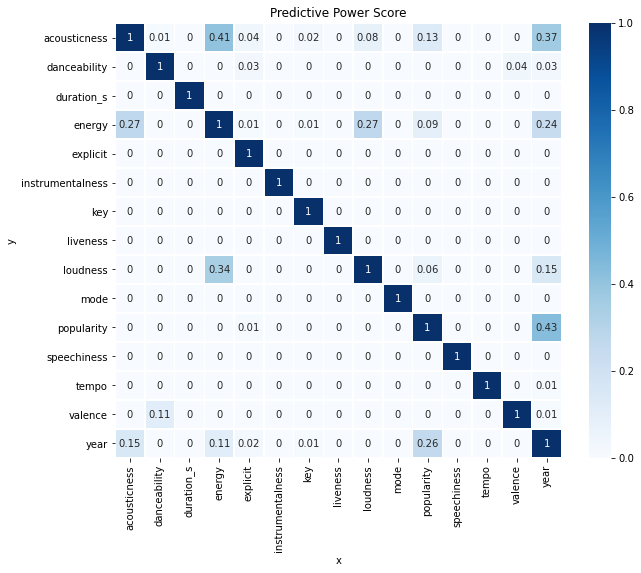

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.title('Predictive Power Score')
plt.show()

PPS показывает, насколько переменная 'x' лучше предсказывает 'y', чем наивное предсказание. (https://github.com/8080labs/ppscore#calculation-of-the-pps)

In [30]:
num_cols_wout_year = num_cols.copy()
num_cols_wout_year.remove('year')

### Изменение метрик в течение всего времени

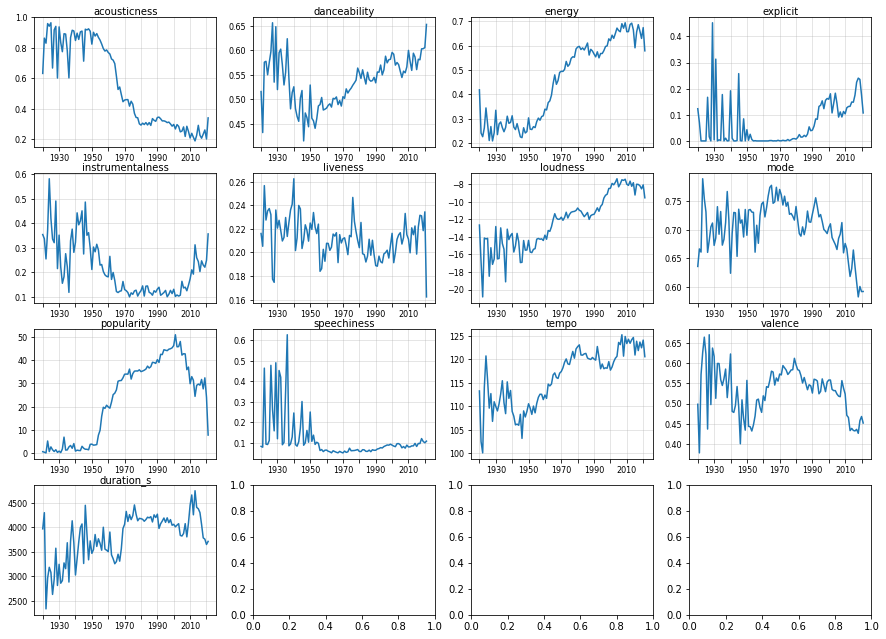

In [26]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15, 11))
for i, col in enumerate(num_cols_wout_year):
    ax[i // 4, i % 4].plot(data[[col, 'year']].groupby('year').mean())
    ax[i // 4, i % 4].set_title(col, fontsize=10, y=0.97)
    
    x = np.arange(min(year.year), max(year.year) + 1, 10)
    ax[i // 4, i % 4].set_xticks(x)
    plt.setp(ax[i // 4, i % 4].get_xticklabels()[::2], visible=False)
    
    ax[i // 4, i % 4].tick_params(axis="x", labelsize=8)
    ax[i // 4, i % 4].tick_params(axis="y", labelsize=8) 

    ax[i // 4, i % 4].grid(alpha=0.4)

**Выводы:** в пятидесятых начала падать акустичность. Можно найти рост продаж электрических гитар в 1963 году (https://teachrock.org/wp-content/uploads/Electric_Guitar_Sales_Graph.jpg)    
В 1940-х доминировал джаз, далее - рок-н-ролл. Может он более танцевален, чем джаз. Скачок в танцевальности в 1970-х обусловлен приходом электронной музыки (https://www.youtube.com/watch?v=16V0tsldP1s).    
Энергичность очень сильно обратно пропорциональна акустичности, поэтому видим похожие тренды.     
Нецензурная лексика (и определённые темы, как секс, расизм) стали более популярными среди песен в 1990-х. (https://github.com/mspbannister/dand-p4-billboard/blob/master/Billboard_analysis__100417_.md#explicit-lyrics)     
Инструментальность упала в 1970-е, когда очень многие песни стали содержать слова.     
Громкость кто только не исследовал, но тренд понятен. Музыка становилась всё громче. Причём видим два скачка - в 1960-х и 1990-х. Теперь каждый может на цифровом секвенсоре применить компрессию и поднять среднюю громкость.     
Сейчас музыку пишут в минорном ключе чаще, чем когда-либо ранее.     
Популярность - внутренняя метрика Spotify. Наверняка популярность измеряется в продажах пластинок, дисков и цифровых альбомов, поэтому она начала расти в 1950-х, опустилась в 2000-х, когда музыку можно было нелегально скачать. Хотя вряд ли уменьшилось прослушивание музыки в целом.     
Темп начал стабильно расти после Второй мировой войны. Потому что удобнее танцевать под более быструю музыку. Наверное...     
Увеличение длительности музыки в 1960-х возможно связан в переходом на цифровые носители.     
И в целом анализ слов показал, что музыка становится более негативной (https://opendatascience.com/popular-music-lyrics-have-become-more-negative-over-the-decades/), но точно не знаем, что имеют ввиду разработчики Spotify под Valence.

## вопросы мусорка
1. смена группой направления
2. самые выдающиеся экспериментальные песни. А что это за метрика - экспериментальные песни, смена направления? Как её обозначить?
3. что ценят люди в разное время. То есть предикторы популярности. Вроде выполнено.
4. взлёты и падения групп
5. запарсить может слова. Провести семантический анализ успешных песен. По жанрам. По ост. характеристикам.
6. Просто сравнить жанры.

# Вопросы
1. Предикторы популярности песен. И добавить группы в предикторы.
2. Проанализировать жанры. Может у кого-нибудь вторая волна была?
3. При помощи расстояний наколдовать сильную смену группой направления.
4. 
5. 
6. 

# 1. Все секреты популярности
я преувеличил

Сразу замечу, что иногда изучают выдающиеся синглы или чарты (плохо разбираюсь в терминологии). Я же просто беру все песни подряд. Чарты уже подразумевают, что песни заполучили популярность.

In [27]:
# data.artists.value_counts()[:15]
# там есть писатели!! Но делаю вид, что они отрезаются после фильтрации.

In [28]:
# data_scale.popularity.hist()

In [29]:
num_cols.remove('year')

In [30]:
def find_predictor_coefs(data, delay = 5):
    """
    delay - промежуток времени, на котором модель учит линейную модель. И этот промежуток сдвигается на 1 год на каждом шаге.
    """
    curr_year = min(year.year)
    last_year = curr_year + delay
    coefs = []
    r2_sq = {}
    while last_year <= 2021:
        df = data[data.year.isin(np.arange(curr_year, last_year+1))]
        X = df[num_cols].drop('popularity', axis=1)
        y = df['popularity']
        model = LinearRegression()
        model.fit(X, y)
        coefs.append(model.coef_)
        r2_sq[curr_year] = r2_score(y, model.predict(X))
        curr_year += 1
        last_year += 1
#     заменяем индексы на года
    coefs = pd.DataFrame(coefs)
    coefs['year'] = np.arange(min(year.year), max(year.year) - delay + 1)
    coefs = coefs.set_index('year')
    
    predictors = num_cols.copy()
    predictors.remove('popularity')
    coefs.columns = predictors
    return coefs, delay, pd.Series(r2_sq)

In [31]:
def plot_coefs(data, squared_r):
    predictors = num_cols.copy()
    predictors.remove('popularity')
    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(12, 10))
    for i, col in enumerate(predictors):
        ax[i // 4, i % 4].plot(coefs[col])
    #     ax[i // 4, i % 4].set_xticks(np.arange(min(year.year), max(year.year) - 4))
        ax[i // 4, i % 4].set_title(col)
    i = 12
    ax[i // 4, i % 4].plot(r2_sq, color='red')
    ax[i // 4, i % 4].set_title('R Squared')
#     ax[i // 4, i % 4].set_xticks(np.arange(min(year.year), max(year.year) + 1), 10)
    fig.suptitle('Running mean over the period of ' + str(delay) + ' years')
    plt.show()

In [32]:
data_scale = data.copy()
scaler = MinMaxScaler()
num_cols_wout_y = num_cols.copy()
num_cols_wout_y.remove('popularity')
num_cols_wout_y.remove('mode')
data_scale[num_cols_wout_y] = scaler.fit_transform(data_scale[num_cols_wout_y])

In [33]:
# coefs, delay, r2_sq = find_predictor_coefs(data_scale, delay = 10)

In [34]:
# plot_coefs(data=coefs, squared_r=r2_sq)

In [35]:
def most_imp_coefs(coefs, n=5):
    most_imp_coefs = coefs.abs().sum(axis=0).sort_values(ascending=False)[:7].index
    coefs[most_imp_coefs].plot(figsize=(10, 8))
    plt.title(f'{n} most important scaled coefficients over time')
    plt.grid(alpha=0.3)
    plt.xticks(np.arange(min(year.year), max(year.year) - delay + 1, 10))
    plt.show()

In [36]:
# most_imp_coefs(5)

Но есть очень сильная аномалия в target, которая может сильно влиять на постраиваемые модели.

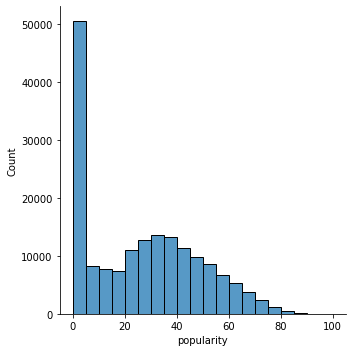

In [37]:
sns.displot(data_scale.popularity, kind='hist', binwidth=5)

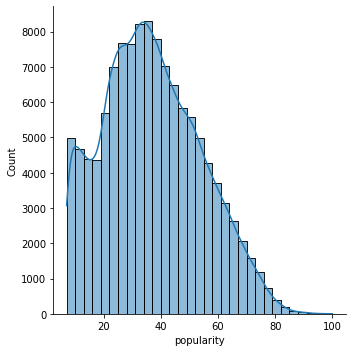

In [38]:
sns.displot(data_scale[data_scale.popularity > 6].popularity, kde=True, binwidth=3)

In [39]:
coefs, delay, r2_sq = find_predictor_coefs(data_scale[data_scale.popularity > 3], delay = 15)

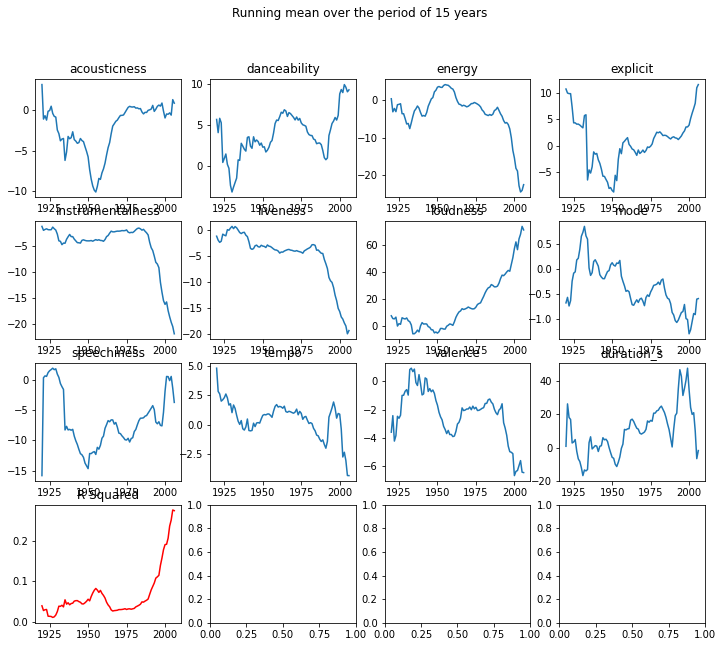

In [40]:
plot_coefs(data=coefs, squared_r=r2_sq)

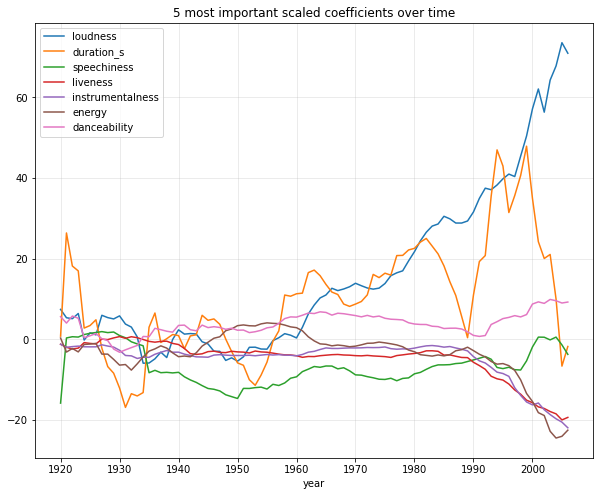

In [41]:
most_imp_coefs(coefs, 5)

Предсказываем немного. Что понятно. Ведь мы музыку любим не просто из-за громкости или наличия электронных инструментов. Только популярность группы наверное (вопрос) предсказывает больше, чем все эти метрики.      
Подразумевая, что популярность песни == человеку понравилось, можем сделать следующие выводы:     
Начиная с конца 1970-х люди начали любить более короткие песни. И более громкие. Это самая яркая закономерность.

# 2. Жанры

Функция должна получить исполнителей, поискать по каждому жанр. И соединить жанры. И добавить эти жанры к каждой песне. Не всегда это будет правильно, но иначе никак. (Если Людовико Эйнауди исполнил Кэти Пэри, то это какой жанр?)

In [42]:
wgenres['genres'] = wgenres['genres'].apply(lambda x: ast.literal_eval(x))

In [43]:
data['artists'] = data['artists'].apply(lambda x: ast.literal_eval(x))

In [44]:
def get_genres(artists):
    all_genres = []
    for artist in artists:
        try:
#             хотя лучше было бы написать через индексы с непустыми списками
            all_genres.extend(wgenres[wgenres['artists'] == artist].genres.to_list()[0])
        except IndexError:
            pass
    return all_genres

In [45]:
# data['genres'] = data['artists'].apply(get_genres) # долгая операция
# data.to_csv('full_data_w_genres.csv', index=None)
full_data = pd.read_csv('full_data_w_genres.csv')
for col in ['artists', 'genres']:
    full_data[col] = full_data[col].apply(lambda x: ast.literal_eval(x))

In [46]:
all_genre_songs = []
for row in full_data.genres:
    all_genre_songs.extend(row)
#     for elem in row:
#         all_genre_songs.append(elem)

In [47]:
pd.Series(all_genre_songs).value_counts()[:8]

rock               23422
adult standards    17709
classic rock       17336
classical          16156
mellow gold        14514
album rock         12511
folk rock          12147
soft rock          12052
dtype: int64

In [48]:
pd.Series(all_genre_songs).nunique()

3231

In [49]:
# dic_of_grouped_df = {}
# for genre in pd.Series(all_genre_songs).value_counts().index:
#     series = full_data[full_data['genres'].apply(lambda x: genre in x)].groupby('year').count().iloc[:, 0]
#     dic_of_grouped_df[genre] = series

In [50]:
# count_genres_by_year = pd.DataFrame(dic_of_grouped_df).fillna(0)
# count_genres_by_year.to_csv('count_genres_by_year.csv', index=True)

In [51]:
count_genres_by_year = pd.read_csv('count_genres_by_year.csv', index_col='year')

In [52]:
count_genres_by_year.columns[:20]

Index(['rock', 'adult standards', 'classic rock', 'classical', 'mellow gold',
       'album rock', 'folk rock', 'soft rock', 'country rock',
       'classical performance', 'vocal jazz', 'lounge', 'soul', 'art rock',
       'hard rock', 'cool jazz', 'rap', 'jazz', 'brill building pop', 'bebop'],
      dtype='object')

In [53]:
# count_genres_by_year

In [54]:
# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
# x = count_genres_by_year.index
# for genre in count_genres_by_year.columns[:10]:
#     y = count_genres_by_year[genre].values
#     yhat =  savgol_filter(y, 21, 3)
#     ax = sns.lineplot(x=x, y=yhat, label=genre, ax=ax)
# plt.grid()

In [55]:
all_words = []
for i in count_genres_by_year.columns:
    all_words.extend(i.split())

In [56]:
pd.Series(all_words).value_counts()[:10]

pop          257
indie        228
rock         192
metal        156
classical    113
hop          111
hip          109
jazz          96
folk          85
punk          80
dtype: int64

очень много повторяющихся жанров

Я вот люблю классику. Думаю, что она стала менее популярна. Но может некоторые жанры пережили себя, но зародились новые?

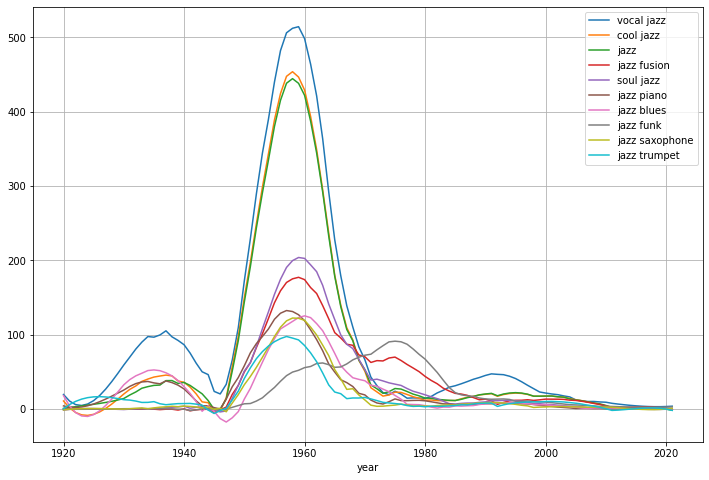

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
x = count_genres_by_year.index
key = 'jazz'
columns_genres = count_genres_by_year.columns
genres_key = columns_genres[columns_genres.str.contains(key)]
for genre in genres_key[:10]:
    y = count_genres_by_year[genre].values
    yhat =  savgol_filter(y, 21, 3)
    ax = sns.lineplot(x=x, y=yhat, label=genre, ax=ax)
plt.grid()

Проблема в том, что есть действительно выдающиеся жанры, появившиеся недавно, но они менее популярны.

In [58]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
d = count_genres_by_year.iloc[:, count_genres_by_year.columns.str.contains('classical')]
model.fit(d)

TimeSeriesKMeans(max_iter=10, metric='dtw')

In [59]:
model.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

И как-нибудь их отобразить на одном или нескольких графиках

# 3. Смена жанра 

In [60]:
count_artists = pd.Series([len(i.split()) for i in data_scale['artists']])

In [61]:
all_artists = []
# [all_artists.append(i) for i in data['artists']]
for i in data['artists']:
    all_artists.extend(i)

In [62]:
artist_counts = pd.Series(all_artists).value_counts()
top_artists = artist_counts[artist_counts >= 20].index.to_list()

In [85]:
len(top_artists)

2249

In [63]:
data_scale['year'] = data['year']

In [95]:
data_scale.artists.apply(lambda x: len(set(top_artists).intersection(set(x))) != 0).sum()

846

In [88]:
data_scale.shape

(174389, 19)

In [90]:
top_artists[0]

'Francisco Canaro'

In [92]:
data_scale[data_scale.artists.str.contains(top_artists[0])]

,acousticness,artists,danceability,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,duration_s
8,1.000000,['Francisco Canaro'],0.474696,0.238,0.0,02i59gYdjlhBmbbWhf8YuK,0.9600,8,0.149,0.646512,1,La Chacarera - Remasterizado,0,1920-07-08,0.076313,0.534112,0.621,1920,0.026607
11,1.000000,['Francisco Canaro'],0.586032,0.356,0.0,0ANuF7SvPeIHanGcCpy9jR,0.9480,10,0.174,0.711393,1,Desengaño - Remasterizado,0,1920-07-08,0.040577,0.540001,0.703,1920,0.030427
17,1.000000,['Francisco Canaro'],0.473684,0.533,0.0,0KGiP9EW1xtojDHsTGARL5,0.8700,1,0.179,0.767332,1,El Africano - Remasterizado,0,1920-07-08,0.046550,0.560859,0.728,1920,0.032342
63,1.000000,['Francisco Canaro'],0.373482,0.285,0.0,1QI5WTvnpNV5vJJQU4DPX1,0.9380,7,0.193,0.680871,1,El Baccarat - Remasterizado,0,1920-07-08,0.054377,0.532050,0.635,1920,0.030629
93,1.000000,['Francisco Canaro'],0.438259,0.322,0.0,2ijTs6mInatQG5cbElWaP3,0.9830,9,0.216,0.687855,1,Tierrita - Remasterizado,0,1920-07-08,0.042636,0.548300,0.763,1920,0.026959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159390,0.952811,"['Francisco Canaro', 'Guillermo Coral']",0.522267,0.430,0.0,5IjRgu3EkwG3IixitC5FzE,0.1890,0,0.381,0.794801,0,Encuentro - Remasterizado,0,1945-03-12,0.112255,0.521353,0.821,1945,0.025492
159438,0.985944,"['Francisco Canaro', 'Carlos Roldán']",0.562753,0.548,0.0,5RgqvFWtwhSlTNzl474ild,0.8530,0,0.372,0.780612,0,Adelaida - Remasterizado,0,1945-03-12,0.069413,0.421397,0.793,1945,0.026654
159472,0.961847,"['Francisco Canaro', 'Guillermo Coral']",0.723684,0.225,0.0,5Yb3BDlyQ4jDiGMPGwScX8,0.0134,7,0.115,0.753864,0,Duelo Criollo - Remasterizado,0,1945-03-13,0.074047,0.522108,0.690,1945,0.028259
159814,0.984940,"['Francisco Canaro', 'Nelly Omar']",0.398785,0.417,0.0,43SxjSuVlR4lxf9yuvSHks,0.8110,6,0.413,0.797009,0,Desde el Alma - Remasterizado,0,1949-03-14,0.086818,0.281450,0.678,1949,0.031397


In [64]:
np.linalg.norm(data_scale[num_cols].iloc[0, :] - data_scale[num_cols].iloc[1, :])

5.05364426547758

In [65]:
data.columns

Index(['acousticness', 'artists', 'danceability', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'name',
       'popularity', 'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'duration_s'],
      dtype='object')

In [66]:
data_scale['artists']

0                            ['Mamie Smith']
1                  ["Screamin' Jay Hawkins"]
2                            ['Mamie Smith']
3                        ['Oscar Velazquez']
4                                   ['Mixe']
                         ...                
174384    ['DJ Combo', 'Sander-7', 'Tony T']
174385                      ['Alessia Cara']
174386                         ['Roger Fly']
174387                      ['Taylor Swift']
174388                         ['Roger Fly']
Name: artists, Length: 174389, dtype: object

In [67]:
art_year_mean = data_scale.groupby(['artists', 'year']).mean()

In [68]:
art_year_mean.shape

(58266, 14)

In [69]:
artists_years = {}
for artist, year in art_year_mean.index:
    if artist not in artists_years:
        artists_years[artist] = [year]
    else:
        artists_years[artist].append(year)


In [70]:
count_years = {artist: len(year) for artist, year in artists_years.items()}

<AxesSubplot:>

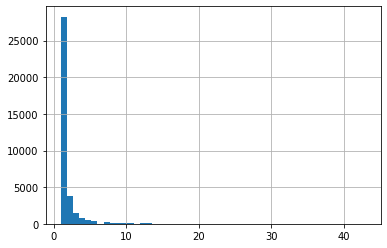

In [71]:
pd.Series(count_years).sort_values().hist(bins=50)

In [72]:
np.sum(pd.Series(count_years) >= 10)

409

409 исполнителей исполнителей выпускали музыку 10 и более лет

А сколько в данных совместных исполнителей?

In [73]:
count_artists = pd.Series([len(i.split()) for i in data_scale['artists']])

<AxesSubplot:>

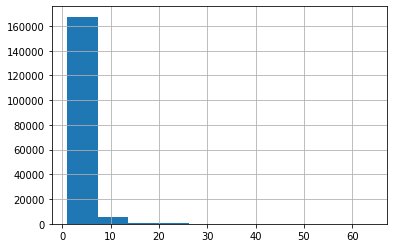

In [74]:
count_artists.hist(bins=10)

In [75]:
count_artists.mean()

2.94302966356823

Эмм. Тогда нельзя слепо разделять артистов по названию.
Можно найти самых общительных (которые встречались с большим кол-вом артистов)    
Что то можно с уменьшением размерности. И ещё расстояния может...

А какие есть жанры

In [71]:
# genres_list = []
# for genres in wgenres['genres']:
#     for genre in ast.literal_eval(genres):
#         genres_list.append(genre)

In [ ]:
pd.Series(genres_list).value_counts()[:10]

А ещё жанры между собой пересекаются по названию

In [ ]:
# wgenres[wgenres['genres'].str.contains('russian pun')]

In [ ]:
top_20_genres = pd.Series(genres_list).value_counts()[:20].index.to_list()

In [ ]:
for genre in top_20_genres:
    wgenres[wgenres['genres'].str.contains(genre)]

Выполнить merge с основной таблицей видимо

In [ ]:
wgenres[wgenres['genres'].str.contains(top_20_genres[0])].groupby('year').count()

In [ ]:
wgenres.columns

In [ ]:
wlyrics = pd.read_csv('spotify_songs.csv')

In [ ]:
wlyrics.head(3)

In [ ]:
wlyrics.columns

In [ ]:
wlyrics[wlyrics.language == 'en'].lyrics

In [ ]:
data.columns

id, к сожалению, не уникальные. Поэтому соединяем по названиям

In [ ]:
pd.merge(data, wlyrics, how='right', right_on='track_name', left_on='name')
# очень грубо

In [ ]:
# https://www.quora.com/Whats-a-good-API-to-use-to-get-song-lyrics

def get_lyrics(artist,song_title): 
    artist = artist.lower() 
    song_title = song_title.lower() 
    # remove all except alphanumeric characters from artist and song_title 
    artist = re.sub('[^A-Za-z0-9]+', "", artist) 
    song_title = re.sub('[^A-Za-z0-9]+', "", song_title) 
    if artist.startswith("the"):    # remove starting 'the' from artist e.g. the who -> who 
        artist = artist[3:] 
    url = "http://azlyrics.com/lyrics/"+artist+"/"+song_title+".html" 
     
    try: 
        content = urllib.request.urlopen(url).read() 
        soup = BeautifulSoup(content, 'html.parser') 
        lyrics = str(soup) 
        # lyrics lies between up_partition and down_partition 
        up_partition = '<!-- Usage of azlyrics.com content by any third-party lyrics provider is prohibited by our licensing agreement. Sorry about that. -->' 
        down_partition = '<!-- MxM banner -->' 
        lyrics = lyrics.split(up_partition)[1] 
        lyrics = lyrics.split(down_partition)[0] 
        lyrics = lyrics.replace('<br>','').replace('</br>','').replace('</div>','').strip() 
        return lyrics 
    except Exception as e: 
        return "Exception occurred \n" +str(e) 

In [ ]:
get_lyrics('Neck Deep', 'December')